In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from einops import rearrange
import ot
import ot.plot
import numpy as np

/Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
source_transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,))
        ])
source_train = datasets.MNIST('../data', train=True, download=True,
                   transform=source_transform)
source_test = datasets.MNIST('../data', train=False,
                   transform=source_transform)

In [3]:
target_transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,)),
    transforms.GaussianBlur(kernel_size=(19, 19), sigma=2.0)
        ])
target_train = datasets.MNIST('../data', train=True, download=True,
                   transform=target_transform)
target_test = datasets.MNIST('../data', train=False,
                   transform=target_transform)

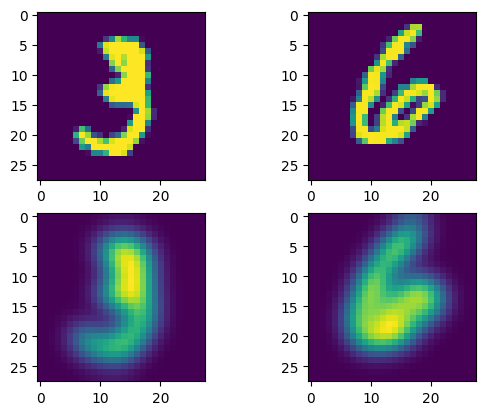

In [98]:
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(rearrange(source_train.__getitem__(10)[0], "c h w -> h w c"))
axarr[0, 1].imshow(rearrange(source_train.__getitem__(13)[0], "c h w -> h w c"))
axarr[1, 0].imshow(rearrange(target_train.__getitem__(10)[0], "c h w -> h w c"))
axarr[1, 1].imshow(rearrange(target_train.__getitem__(13)[0], "c h w -> h w c"))

In [99]:
s1 = rearrange(source_train.__getitem__(10)[0], "c h w -> h (w c)")
t1 = rearrange(target_train.__getitem__(10)[0], "c h w -> h (w c)")

In [100]:
s1 /= s1.sum()
t1 /= t1.sum()

In [101]:
M = ot.dist(np.indices(s1.shape).reshape(2, -1).T, np.indices(t1.shape).reshape(2, -1).T)

In [102]:
s1.shape

torch.Size([28, 28])

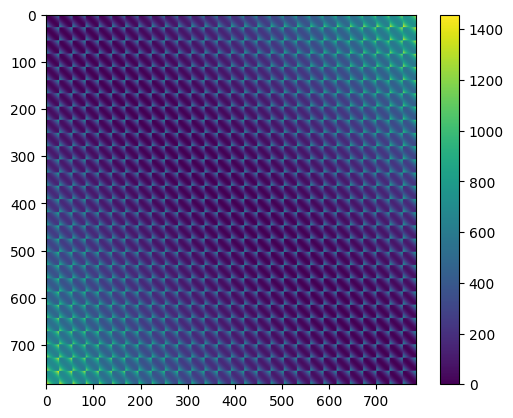

In [103]:
plt.imshow(M)
plt.colorbar()
plt.show()

In [108]:
coupling = ot.sinkhorn(a=s1.reshape(-1), b=t1.reshape(-1), M=torch.tensor(M), reg=5.0, numItermax=400, verbose=True)

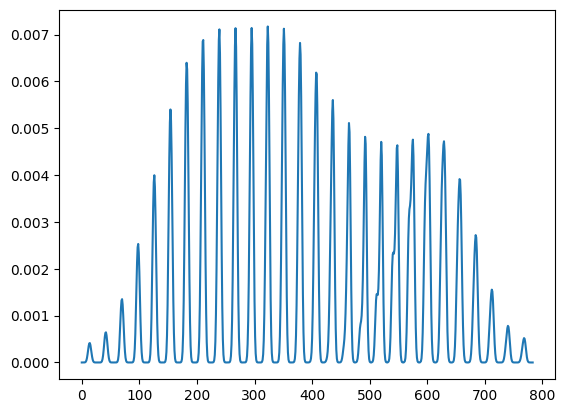

In [109]:
plt.plot(t1.reshape(-1))

In [110]:
coupling.shape

torch.Size([784, 784])

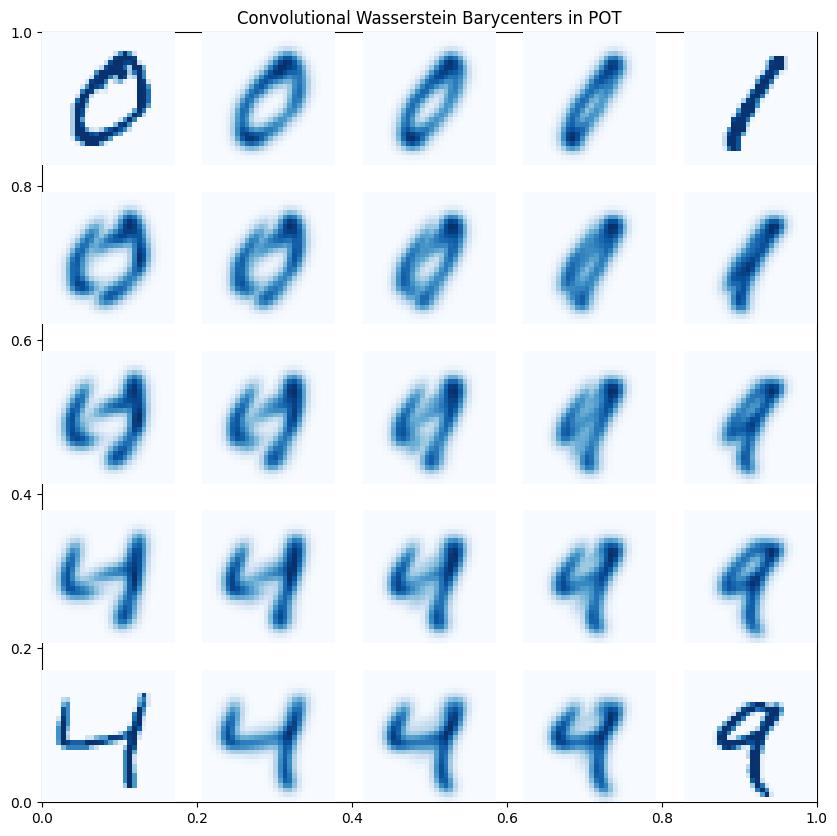

In [123]:
import matplotlib.pylab as pl

f1 = rearrange(source_train.__getitem__(1)[0], "c h w -> h (w c)")
f2 = rearrange(source_train.__getitem__(2)[0], "c h w -> h (w c)")
f3 = rearrange(source_train.__getitem__(3)[0], "c h w -> h (w c)")
f4 = rearrange(source_train.__getitem__(4)[0], "c h w -> h (w c)")

f1 = f1 / torch.sum(f1)
f2 = f2 / torch.sum(f2)
f3 = f3 / torch.sum(f3)
f4 = f4 / torch.sum(f4)

A = [f1, f2, f3, f4]

v1 = np.array((1, 0, 0, 0))
v2 = np.array((0, 1, 0, 0))
v3 = np.array((0, 0, 1, 0))
v4 = np.array((0, 0, 0, 1))

nb_images = 5

pl.figure(figsize=(10, 10))
pl.title('Convolutional Wasserstein Barycenters in POT')
cm = 'Blues'
# regularization parameter
reg = 0.004
for i in range(nb_images):
    for j in range(nb_images):
        pl.subplot(nb_images, nb_images, i * nb_images + j + 1)
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        if i == 0 and j == 0:
            pl.imshow(f1, cmap=cm)
            pl.axis('off')
        elif i == 0 and j == (nb_images - 1):
            pl.imshow(f3, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == 0:
            pl.imshow(f2, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == (nb_images - 1):
            pl.imshow(f4, cmap=cm)
            pl.axis('off')
        else:
            # call to barycenter computation
            pl.imshow(ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm)
            pl.axis('off')
pl.show()

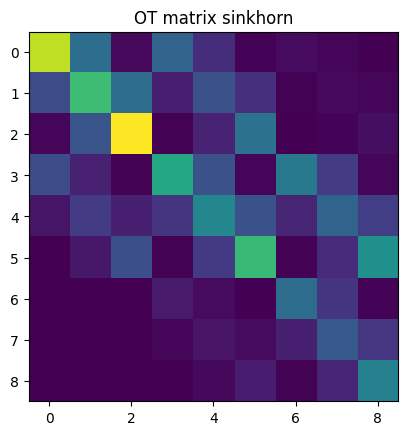

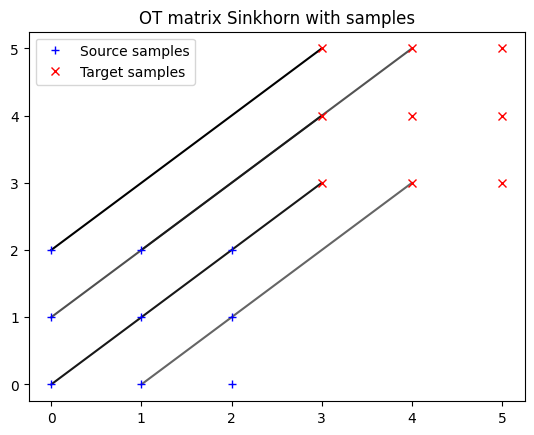

In [90]:
import matplotlib.pylab as pl

coupling = coupling

pl.figure(5)
pl.imshow(coupling, interpolation='nearest')
pl.title('OT matrix sinkhorn')

xs = np.indices(s1.shape).reshape(2, -1).T
xt = np.indices(t1.shape).reshape(2, -1).T

pl.figure(6)
ot.plot.plot2D_samples_mat(xs=xs, xt=xt+3, G=coupling, thr=0.6)
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0] + 3, xt[:, 1] + 3, 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix Sinkhorn with samples')

pl.show()

In [85]:
coupling

array([[7.14364052e-02, 2.84756459e-02, 2.00062874e-03, 2.52205022e-02,
        1.02941273e-02, 7.47573795e-04, 2.27509369e-03, 9.79078235e-04,
        7.51269472e-05],
       [1.84871797e-02, 5.44519685e-02, 2.82680262e-02, 6.52686693e-03,
        1.96847338e-02, 1.05628977e-02, 5.88776311e-04, 1.87222240e-03,
        1.06151158e-03],
       [9.46017506e-04, 2.05888022e-02, 7.89772347e-02, 3.33989854e-04,
        7.44298333e-03, 2.95113809e-02, 3.01285927e-05, 7.07904925e-04,
        2.96572712e-03],
       [1.83248818e-02, 7.30457902e-03, 5.13201754e-04, 4.78040054e-02,
        1.95119251e-02, 1.41698308e-03, 3.18638943e-02, 1.37125105e-02,
        1.05219276e-03],
       [4.62799333e-03, 1.36312507e-02, 7.07648508e-03, 1.20730186e-02,
        3.64116728e-02, 1.95386335e-02, 8.04730318e-03, 2.55892463e-02,
        1.45085752e-02],
       [2.31498430e-04, 5.03825303e-03, 1.93263944e-02, 6.03908498e-04,
        1.34581355e-02, 5.33614196e-02, 4.02536883e-04, 9.45805293e-03,
        3.9

In [87]:
s1

tensor([[0.1415, 0.1415, 0.1415],
        [0.1415, 0.1415, 0.1415],
        [0.0496, 0.0496, 0.0518]])

In [91]:
t1

tensor([[0.1144, 0.1299, 0.1366],
        [0.0997, 0.1149, 0.1239],
        [0.0785, 0.0946, 0.1074]])

In [111]:
np.sum(coupling, axis=1)

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=int, ), but expected one of:
 * (*, torch.dtype dtype = None)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


In [92]:
np.sum(coupling, axis=0)

array([0.1144254 , 0.12990317, 0.1365919 , 0.09972178, 0.11494849,
       0.12391043, 0.07846963, 0.09461433, 0.10741485], dtype=float32)

MovieWriter ffmpeg unavailable; using Pillow instead.


......

ValueError: unknown file extension: 

.

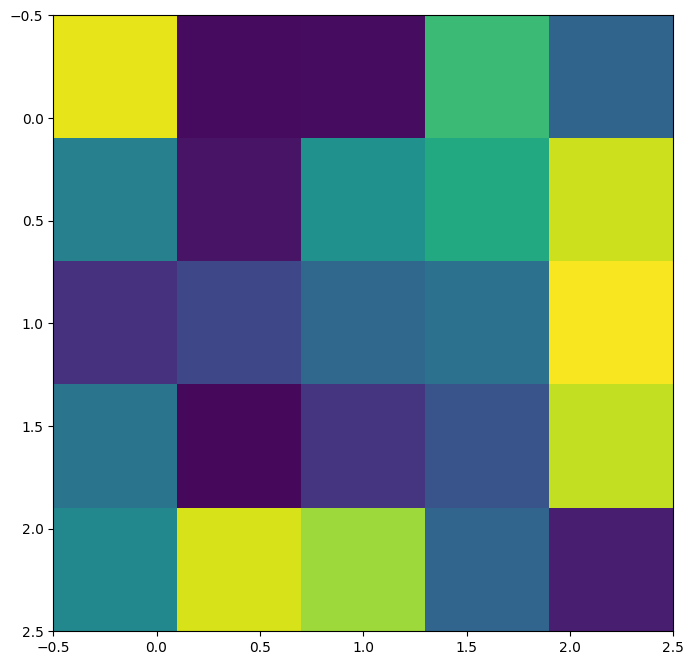

In [97]:
hmpf = s1

def make_frame(t):
    

imagelist = [ hmpf*i*255./19. for i in range(20) ]

import matplotlib.pyplot as plt
import matplotlib.animation as animation
fig = plt.figure() # make figure

# make axesimage object
# the vmin and vmax here are very important to get the color map correct
im = plt.imshow(imagelist[0], cmap=plt.get_cmap('jet'), vmin=0, vmax=255)

# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(imagelist[j])
    # return the artists set
    return [im]
# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, frames=range(20), 
                              interval=50, blit=True)
plt.show()